# Import libraries

In [7]:
import os

import numpy as np
import pandas as pd


# Read data

In [8]:
DATASET_PATH = '../../data/processed/HAR'
DATASET_CSV_PATH = f'{DATASET_PATH}/UCF'

In [9]:
LABEL = {
    'Jump': 0,
    'Kick': 1,
    'Punch': 2,
    'Left': 3,
    'Right': 4,
    'Stand': 5
}

In [10]:
X = []
y = []

# Read all files in the dataset
for label in LABEL:
    for file in os.listdir(f'{DATASET_CSV_PATH}/Train/{label}'):
        df = pd.read_csv(f'{DATASET_CSV_PATH}/Train/{label}/{file}', sep=',')
        X.append(df)
        y.append(LABEL[label])

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../../data/processed/HAR/UCF/Train/Jump'

In [11]:
# Drop frame_num and timestamp columns
for i, element in enumerate(X):
    if 'frame_num' and 'timestamp' in element.columns:
        X[i] = element.drop(columns=['frame_num', 'timestamp'])


In [12]:
for i, element in enumerate(X):
    for column in element.columns:
        X[i][column] = X[i][column].apply(lambda x: np.array(x[1:-1].split(',')).astype(np.float32))

## Convert All Sequences to the Same Length

In [13]:
# Get the maximum length of all sequences
all_dim = []
for i, element in enumerate(X):
    all_dim.append(element.shape[0])
    # print(f"Element {i} shape: {np.shape(element)}, label: {y[i]}")

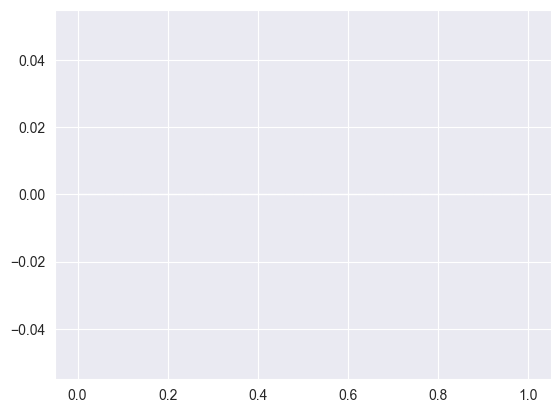

In [14]:
# Visualize the distribution of the lengths of all sequences
import matplotlib.pyplot as plt

plt.hist(all_dim, bins=50)
plt.show()

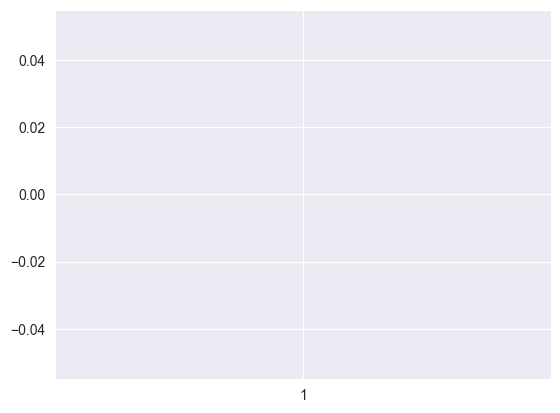

In [15]:
# Visualize the boxplot of the lengths of all sequences
plt.boxplot(all_dim)
plt.show()

### Handle the Outliers and make the lengths of all sequences the same
Handle different lengths of sequences
    Set the maximum length = 1.5 * IQR + Q3
    
    * Case 1: If e_dim < Max_dim, then increase the length of the sequence by duplicating each row until the length of the sequence is equal to Max_dim
    * Case 2: If e_dim > Max_dim, then truncate randomly the sequence until the length of the sequence is equal to Max_dim
    * Case 3: If e_dim = Max_dim, then keep the sequence as it is

In [16]:
# Convert all sequences to the same length
Q1 = np.percentile(all_dim, 25)
Q3 = np.percentile(all_dim, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}, Lower bound: {lower_bound}, Upper bound: {upper_bound}")

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
# # Drop outliers
# for i, element in enumerate(X):
#     if element.shape[0] < lower_bound or element.shape[0] + 1 > upper_bound:
#         X.pop(i)
#         y.pop(i)

In [ ]:
Max_dim = 35

In [ ]:
X[0].shape

In [ ]:
test = X[0]
test.shape

In [ ]:
test_np = np.array(test)

In [ ]:
test_np[0]

In [ ]:
X_train_temp = []
Y_train_temp = []


def pad_length(ele, max_dim, metric_temp: list = None) -> np.array:
    if metric_temp is None:
        metric_temp = []
    if ele.shape[0] == max_dim:
        return ele

    step = max(1, ele.shape[0] // (max_dim - ele.shape[0]))

    for j in range(0, ele.shape[0]):
        metric_temp.append(ele[j])
        if len(metric_temp) == max_dim:
            break
        if j % step == 0:
            metric_temp.append(ele[j])
        if len(metric_temp) == max_dim:
            break
    return pad_length(np.array(metric_temp), max_dim)


def truncate_length(ele, max_dim, start=0) -> np.array:
    if ele.shape[0] == max_dim:
        return pd.DataFrame(ele)

    metrics_temp = []
    step = max(2, ele.shape[0] // (ele.shape[0] - max_dim))
    j = start
    while len(metrics_temp) != max_dim:
        metrics_temp.append(ele[j])
        j = (j + step) % ele.shape[0]
    return np.array(metrics_temp)


def pad_and_truncate(ele, max_dim: int = 35) -> np.array:
    list_elements = []
    current_length = ele.shape[0]

    if current_length == max_dim:
        return [ele]

    dev = max(int(round(current_length / max_dim)), 1)
    if dev * max_dim > current_length:
        new_element = pad_length(ele, max_dim * dev)

        if new_element.shape[0] > max_dim:
            for step in range(dev):
                list_elements.append(truncate_length(new_element, max_dim, step))
        else:
            list_elements.append(new_element)
    else:
        for step in range(dev):
            list_elements.append(truncate_length(ele, max_dim, step))
    return list_elements


# Pad all sequences to the same length
for i, element in enumerate(X):
    print(f"Before padding, element {i} shape: {np.shape(element)}")
    padded_element = pad_and_truncate(np.array(element), Max_dim)
    print(f"After padding, element {i} shape: {np.shape(padded_element)}")
    X_train_temp = X_train_temp + padded_element
    Y_train_temp = Y_train_temp + [y[i]] * len(padded_element)
    print('y[i]: ', y[i])
    print(f'padded_element: {np.shape(padded_element)}')
    print(f"After padding X_train_temp, element {i} shape: {np.shape(X_train_temp)}")
    print(f"After padding Y_train_temp, element {i} shape: {np.shape(Y_train_temp)}")
    print('-----------------------------------')
# test = X[15]
# padded_element = pad_and_truncate(test, Max_dim)
# np.array(padded_element).shape

In [ ]:
X_train_ = np.array(X_train_temp)

In [ ]:
X_train_temp

In [ ]:
X_train = np.full((X_train_.shape[0], X_train_.shape[1], X_train_.shape[2], 3), np.nan, dtype=np.float32)

for i, element in enumerate(X_train_):
    for j, row in enumerate(element):
        for k, value in enumerate(row):
            # Check if the value is np.array([nan, nan, nan])
            if np.isnan(value).all():
                X_train_[i][j][k] = np.array([np.nan, np.nan, np.nan], dtype=np.float32)
            else:
                X_train_[i][j][k] = value

            X_train[i][j][k] = X_train_[i][j][k][:3]

In [ ]:
X_train.shape

## Handle Fill NaN Values

### Step 1: Compute the variance of each metric for each sequence.

### Step 2: Fill NaN
   * **Case 1**: If `element[i]` doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
   * **Case 2**: If `element[i]` doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
   * **Case 3**: If `element[i]` has values both before and after, then use the nearest previous and posterior elements:
     - For \( k < i < l \):

$$
\text{element}[i] = \text{element}[k] + (\text{element}[l] - \text{element}[k]) \times \frac{i - k}{l - k}
$$


### Step 1: Compute the variance of each metric for each sequence.

In [ ]:
X_train.shape

In [ ]:
cnt = 0

In [ ]:
np.nanvar(X_train[0][:, 0], axis=0)

In [ ]:
variance_metric = np.empty((X_train.shape[0], X_train.shape[2], 3), dtype=np.float32)
variance_metric.shape

In [17]:
X_train[0][:, 0].shape

NameError: name 'X_train' is not defined

In [18]:
np.nanvar(X_train[1][:, 0], axis=0)

NameError: name 'X_train' is not defined

In [19]:
cls_nan = dict()

for i, element in enumerate(X_train):
    sub_variance_metric = np.empty((element.shape[1], 3), dtype=np.float32)

    for j in range(element.shape[1]):
        variance = np.array([np.nan, np.nan, np.nan], dtype=np.float32)

        # If there are more than 1 non-NaN values, calculate variance
        if np.count_nonzero(~np.isnan(element[:, j])) > 1:
            variance = np.nanvar(element[:, j], axis=0)
            print(variance)
        else:
            if i not in cls_nan:
                cls_nan[i] = []
            cls_nan[i].append(j)
        # convert to list
        sub_variance_metric[j] = variance
    # print(sub_variance_metric)
    variance_metric[i] = sub_variance_metric

NameError: name 'X_train' is not defined

In [20]:
variance_metric = np.array([variance_metric], dtype=np.float32)

NameError: name 'variance_metric' is not defined

In [21]:
variance_metric = variance_metric.reshape(variance_metric.shape[1], variance_metric.shape[2], variance_metric.shape[3])

NameError: name 'variance_metric' is not defined

In [22]:
variance_metric.shape

NameError: name 'variance_metric' is not defined

In [23]:
# convert to cls_nan to pandas dataframe
cls_nan.keys()

dict_keys([])

In [24]:
LABEL

{'Jump': 0, 'Kick': 1, 'Punch': 2, 'Left': 3, 'Right': 4, 'Stand': 5}

### Step 2: Fill NaN
   * **Case 1**: If `element[i]` doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
   * **Case 2**: If `element[i]` doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
   * **Case 3**: If `element[i]` has values both before and after, then use the nearest previous and posterior elements:
     - For \( k < i < l \):

$$
\text{element}[i] = \text{element}[k] + (\text{element}[l] - \text{element}[k]) \times \frac{i - k}{l - k}
$$


In [25]:
X_train.shape

NameError: name 'X_train' is not defined

In [26]:
variance_metric.shape

NameError: name 'variance_metric' is not defined

In [27]:
# Function to fill NaN values based on the described cases
def fill_nan(element, variance_metric):
    old_value = None
    k = 0

    for i in range(element.shape[0]):
        if np.isnan(element[i]).all():
            # Case 1: If element[i] doesn't have a value before, then get the value from the nearest posterior element, and adjust by adding or subtracting the variance of the metric.
            if old_value is None:
                for l in range(i + 1, element.shape[0]):
                    if not np.isnan(element[l]).all():
                        element[i] = element[l] + abs(i - l) * variance_metric
                        break
            else:
                # Case 2: If element[i] doesn't have a value after, then get the value from the nearest previous element, and adjust by adding or subtracting the variance of the metric.
                flat = False
                for l in range(i + 1, element.shape[0]):
                    if not np.isnan(element[l]).all():
                        if l != k:
                            element[i] = old_value + (element[l] - old_value) / ((i - k) / (l - k))
                            flat = True
                            break
                if not flat:
                    # Case 3: If element[i] has values both before and after, then use the nearest previous and posterior elements
                    element[i] = old_value - abs(i - k) * variance_metric
        old_value = element[i]
    return element

In [28]:
X_train_new = np.empty(X_train.shape, dtype=np.float32)
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[2]):
        # print("Shape of element: ", X_train[i][: , j].shape)
        # print("Shape of variance: ", variance_metric[i][j].shape)
        X_train_new[i][:, j] = fill_nan(X_train[i][:, j], variance_metric[i][j])

NameError: name 'X_train' is not defined

In [29]:
# Save the processed data
np.save('X_train.npy', X_train_new)
np.save('y_train.npy', Y_train_temp)

NameError: name 'X_train_new' is not defined

In [30]:
import numpy as np

# Load the processed data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

In [31]:
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[2]):
        if np.isnan(X_train[i][:, j]).sum() > 0:
            print(f"Element {i}, Metric {j}, NaN: {np.isnan(X_train[i][:, j]).sum()}")

In [32]:
# Drop the NaN values
X_new_train = []
y_new_train = []
for i in range(X_train.shape[0]):
    if np.isnan(X_train[i]).sum() == 0:
        X_new_train.append(X_train[i])
        y_new_train.append(y_train[i])

X_new_train = np.array(X_new_train)
y_new_train = np.array(y_new_train)


In [33]:
X_train.shape

(666, 35, 33, 3)

In [34]:
for i in range(X_new_train.shape[0]):
    for j in range(X_new_train.shape[2]):
        if np.isnan(X_new_train[i][:, j]).sum() > 0:
            print(f"Element {i}, Metric {j}, NaN: {np.isnan(X_new_train[i][:, j]).sum()}")

In [38]:
len(X_new_train)

666

## LSTM model LSTM model

In [39]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [47]:
X_new_train.shape

(666, 35, 33, 3)

In [41]:
# Reshape the data
X_train_reshaped = X_new_train.reshape(X_new_train.shape[0], X_new_train.shape[1],
                                       X_new_train.shape[2] * X_new_train.shape[3])

In [73]:
X_train_reshaped.shape

(532, 35, 99)

In [43]:
# divide validation set and train set
from sklearn.model_selection import train_test_split

X_train_reshaped, X_val, y_new_train, y_val = train_test_split(X_train_reshaped, y_new_train, test_size=0.2, random_state=42)

In [51]:
hidden_size = [ 1024, 512, 256, 128 ]
lstm_layer = 1
patch_size = 99
num_classes = 6
num_epochs = 100
batch_size = 256
learning_rate = 0.001
momentum = 0.9
number_block = 1
max_dim = 50
device = 'cpu'

In [69]:
from src.models.model import Model
import torch
from torchinfo import summary


In [72]:
X_train_reshaped.shape

(532, 35, 99)

In [70]:
model = Model(
    input_size=X_train_reshaped.shape[2],
    num_classes=num_classes,
    patch_size=patch_size,
    lstm_layer=lstm_layer,
    hidden_size=hidden_size,
    number_block=number_block,
    device=device,
)
summary(model.lstm, input_size=(batch_size, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))

Layer (type:depth-idx)                   Output Shape              Param #
DeepLSTMBiModel                          [256, 6]                  --
├─LSTM: 1-1                              [256, 35, 2048]           9,216,000
├─Dropout: 1-2                           [256, 35, 2048]           --
├─LayerNorm: 1-3                         [256, 35, 2048]           4,096
├─LSTM: 1-4                              [256, 35, 1024]           10,493,952
├─Dropout: 1-5                           [256, 35, 1024]           --
├─LayerNorm: 1-6                         [256, 35, 1024]           2,048
├─LSTM: 1-7                              [256, 35, 512]            2,625,536
├─Dropout: 1-8                           [256, 35, 512]            --
├─LayerNorm: 1-9                         [256, 35, 512]            1,024
├─LSTM: 1-10                             [256, 35, 256]            657,408
├─Dropout: 1-11                          [256, 35, 256]            --
├─LayerNorm: 1-12                        [256, 35

In [68]:
model.lstm

DeepLSTMBiModel(
  (lstm1): LSTM(99, 1024, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (norm1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (lstm2): LSTM(2048, 512, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (lstm3): LSTM(1024, 256, batch_first=True, bidirectional=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (lstm4): LSTM(512, 128, batch_first=True, bidirectional=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)

In [54]:
model.lstm

DeepLSTMBiModel(
  (lstm1): LSTM(99, 1024, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (norm1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
  (lstm2): LSTM(2048, 512, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (lstm3): LSTM(1024, 256, batch_first=True, bidirectional=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (norm3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (lstm4): LSTM(512, 128, batch_first=True, bidirectional=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)

In [53]:
model.fit(
    X_train=X_train_reshaped,
    y_train=y_new_train,
    X_val=X_val,
    y_val=y_val,
    learning_rate=learning_rate,
    epochs=num_epochs,
    device=device,
)

ValueError: batch_size should be a positive integer value, but got batch_size=tensor([1, 3, 2, 0, 1, 2, 0, 1, 2, 5, 3, 4, 1, 2, 2, 2, 5, 4, 4, 1, 5, 2, 4, 3,
        5, 2, 3, 0, 0, 5, 5, 3, 5, 0, 0, 4, 2, 4, 3, 2, 4, 1, 3, 0, 0, 0, 1, 1,
        4, 0, 0, 1, 4, 3, 2, 4, 5, 5, 1, 3, 3, 0, 4, 2, 3, 0, 0, 1, 2, 1, 1, 1,
        5, 2, 1, 2, 0, 1, 4, 0, 0, 2, 4, 5, 2, 0, 5, 2, 4, 4, 1, 1, 4, 0, 2, 5,
        2, 5, 0, 1, 4, 1, 1, 2, 1, 0, 3, 0, 3, 0, 2, 2, 4, 1, 0, 3, 1, 1, 1, 0,
        5, 0, 4, 4, 1, 0, 5, 3, 3, 2, 0, 1, 2, 2, 3, 1, 2, 2, 5, 4, 2, 3, 0, 1,
        1, 5, 5, 0, 3, 4, 4, 5, 2, 5, 2, 1, 2, 1, 0, 4, 4, 1, 3, 3, 5, 2, 5, 1,
        1, 2, 0, 1, 4, 0, 2, 0, 3, 1, 4, 3, 1, 2, 3, 2, 1, 0, 5, 2, 0, 4, 1, 2,
        0, 3, 1, 2, 0, 4, 2, 1, 4, 5, 1, 3, 4, 2, 0, 1, 2, 4, 3, 3, 4, 0, 0, 5,
        4, 4, 0, 0, 5, 5, 0, 3, 3, 2, 2, 3, 2, 5, 1, 0, 4, 1, 0, 2, 1, 0, 1, 1,
        5, 3, 2, 1, 5, 5, 1, 5, 5, 5, 4, 0, 4, 1, 3, 1, 2, 1, 3, 2, 3, 5, 1, 4,
        5, 1, 3, 4, 0, 4, 0, 0, 5, 0, 4, 1, 3, 5, 1, 3, 3, 3, 4, 0, 4, 0, 1, 1,
        2, 4, 4, 2, 0, 0, 3, 3, 4, 1, 4, 2, 3, 1, 3, 1, 4, 2, 5, 0, 0, 3, 3, 2,
        1, 2, 3, 1, 3, 5, 4, 3, 3, 5, 1, 4, 2, 2, 4, 0, 4, 0, 1, 1, 3, 4, 0, 2,
        2, 2, 2, 1, 3, 0, 1, 1, 3, 2, 1, 3, 1, 4, 4, 1, 5, 4, 0, 3, 4, 4, 1, 4,
        2, 0, 1, 0, 5, 4, 1, 5, 3, 4, 0, 4, 3, 5, 2, 2, 0, 3, 4, 0, 1, 4, 3, 1,
        4, 2, 3, 5, 2, 1, 2, 3, 3, 1, 5, 4, 3, 2, 4, 5, 5, 5, 0, 1, 1, 4, 0, 4,
        1, 4, 4, 5, 0, 1, 3, 4, 1, 3, 3, 5, 1, 0, 5, 4, 0, 3, 4, 0, 0, 1, 1, 0,
        4, 1, 4, 3, 2, 3, 3, 4, 1, 0, 3, 0, 5, 4, 0, 0, 1, 0, 4, 3, 1, 1, 0, 2,
        2, 1, 3, 3, 5, 2, 1, 1, 4, 3, 3, 0, 4, 3, 0, 5, 4, 0, 1, 0, 4, 3, 3, 2,
        0, 2, 4, 2, 1, 0, 2, 5, 3, 2, 1, 5, 4, 5, 4, 1, 4, 4, 1, 3, 4, 0, 3, 4,
        1, 0, 2, 3, 1, 2, 1, 3, 3, 4, 2, 2, 0, 0, 2, 0, 3, 2, 1, 3, 0, 5, 0, 0,
        0, 2, 3, 0])

In [368]:
# Save the models
model.save('models.h5')

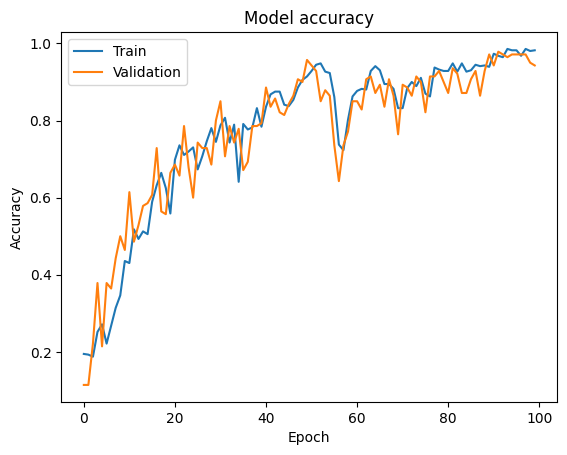

In [369]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [372]:
# Metrics
model.evaluate(X_train_reshaped, y_new_train)

18/18 [==============================] - 2s 110ms/step - loss: 0.0600 - accuracy: 0.9804


[0.05996213108301163, 0.9803571701049805]

In [375]:
# Show the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_train_reshaped)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_train, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

ModuleNotFoundError: No module named 'seaborn'

In [374]:
LABEL

{'Jump': 0, 'Kick': 1, 'Punch': 2, 'Left': 3, 'Right': 4, 'Stand': 5}